In [1]:
import pandas as pd
df = pd.read_csv("Samsung_clean.csv")
print(df.columns)
print(df.head())


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
       Date   Open   High    Low  Close    Adj Close    Volume
0  1/4/2010  16060  16180  16000  16180  11978.36523  11950800
1  1/5/2010  16520  16580  16300  16440  12170.84668  27925850
2  1/6/2010  16580  16820  16520  16820  12452.17090  22948850
3  1/7/2010  16820  16820  16260  16260  12037.59082  22107950
4  1/8/2010  16400  16420  16120  16420  12156.04102  14777550


In [2]:
# Library to support working with data
import numpy as np
import pandas as pd

# Graphing support library
import matplotlib.pyplot as plt

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Library to support building Simple Exponential Smoothing models
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Performance metrics calculation support Library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error


In [3]:
df = pd.read_csv('Samsung_clean.csv')
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,1/4/2010,16060,16180,16000,16180,11978.36523,11950800
1,1/5/2010,16520,16580,16300,16440,12170.84668,27925850
2,1/6/2010,16580,16820,16520,16820,12452.17090,22948850
3,1/7/2010,16820,16820,16260,16260,12037.59082,22107950
4,1/8/2010,16400,16420,16120,16420,12156.04102,14777550


In [4]:
# Ensure column name is correctly recognized
df.columns = df.columns.str.strip()

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows where Date failed to parse
df = df.dropna(subset=['Date'])

# Set the 'Date' column as index
df.set_index('Date', inplace=True)

df.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,16060,16180,16000,16180,11978.36523,11950800
2010-01-05,16520,16580,16300,16440,12170.84668,27925850
2010-01-06,16580,16820,16520,16820,12452.17090,22948850
2010-01-07,16820,16820,16260,16260,12037.59082,22107950
2010-01-08,16400,16420,16120,16420,12156.04102,14777550


In [5]:
df_Close = df[['Close']]
df_Close.head()


,Close
Date,
2010-01-04,16180
2010-01-05,16440
2010-01-06,16820
2010-01-07,16260
2010-01-08,16420


In [6]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))


In [7]:
train_size = int(0.7 * len(data_scaled))
val_size = int(0.1 * len(data_scaled))
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[:train_size]
val_data = data_scaled[train_size: train_size + val_size]
test_data = data_scaled[train_size + val_size:]


In [8]:
best_alpha = None
best_mse = float('inf')
best_rmse = None
best_mape = None
best_msle = None
best_y_pred_val = None


In [10]:
for alpha in np.arange(0.1, 1.0, 0.1):
    alpha = round(alpha, 1)
    history = train_data.copy()
    y_pred_val = []

    for i in val_data:
        model = SimpleExpSmoothing(history)
        model_fit = model.fit(smoothing_level=alpha, optimized=False)
        prediction = model_fit.forecast()[0]
        y_pred_val.append(prediction)
        history = np.append(history, i)

    # inverse transform
    val_temp = scaler.inverse_transform(val_data)
    y_pred_val_inv = scaler.inverse_transform(np.array(y_pred_val).reshape(-1, 1))

    # calculate metrics
    mape = mean_absolute_percentage_error(val_temp, y_pred_val_inv)
    mse = mean_squared_error(val_temp, y_pred_val_inv)
    rmse = np.sqrt(mse)
    msle = mean_squared_log_error(val_temp, y_pred_val_inv)

    if mse < best_mse:
        best_alpha = alpha
        best_mse = mse
        best_rmse = rmse
        best_mape = mape
        best_msle = msle
        best_y_pred_val = y_pred_val_inv

print(f"✅ Best alpha: {best_alpha}")


✅ Best alpha: 0.9


In [11]:
print(f"MAPE on Validate dataset: {best_mape}")
print(f"RMSE on Validate dataset: {best_rmse}")
print(f"MSLE on Validate dataset: {best_msle}")


MAPE on Validate dataset: 0.009723441585915767
RMSE on Validate dataset: 962.209395222931
MSLE on Validate dataset: 0.00016947474334622382


In [12]:
y_pred = []
history = np.concatenate((train_data, val_data), axis=0)

for i in test_data:
    model = SimpleExpSmoothing(history)
    model_fit = model.fit(smoothing_level=best_alpha, optimized=False)
    prediction = model_fit.forecast()[0]
    y_pred.append(prediction)
    history = np.append(history, i)

# inverse transform
test_temp = scaler.inverse_transform(test_data)
y_pred_inv = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))

test_mape = mean_absolute_percentage_error(test_temp, y_pred_inv)
test_mse = mean_squared_error(test_temp, y_pred_inv)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(test_temp, y_pred_inv)

print(f"MAPE on Test dataset: {test_mape}")
print(f"RMSE on Test dataset: {test_rmse}")
print(f"MSLE on Test dataset: {test_msle}")


MAPE on Test dataset: 0.013211697237578743
RMSE on Test dataset: 1212.9140841094575
MSLE on Test dataset: 0.00032002634772973954


In [13]:
last_date = df.index[-1]
next_date = last_date + pd.DateOffset(days=1)
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()


In [14]:
y_next_30_days = []
history = np.concatenate((train_data, val_data, test_data), axis=0)

for i in range(30):
    model = SimpleExpSmoothing(history)
    model_fit = model.fit(smoothing_level=best_alpha, optimized=False)
    prediction = model_fit.forecast()[0]
    y_next_30_days.append(prediction)
    history = np.append(history, prediction)

y_next_30_days_inv = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1))
print("Predicted closing prices for the next 30 days:")
print(y_next_30_days_inv.flatten())


Predicted closing prices for the next 30 days:
[100421.5899575 100421.5899575 100421.5899575 100421.5899575
 100421.5899575 100421.5899575 100421.5899575 100421.5899575
 100421.5899575 100421.5899575 100421.5899575 100421.5899575
 100421.5899575 100421.5899575 100421.5899575 100421.5899575
 100421.5899575 100421.5899575 100421.5899575 100421.5899575
 100421.5899575 100421.5899575 100421.5899575 100421.5899575
 100421.5899575 100421.5899575 100421.5899575 100421.5899575
 100421.5899575 100421.5899575]


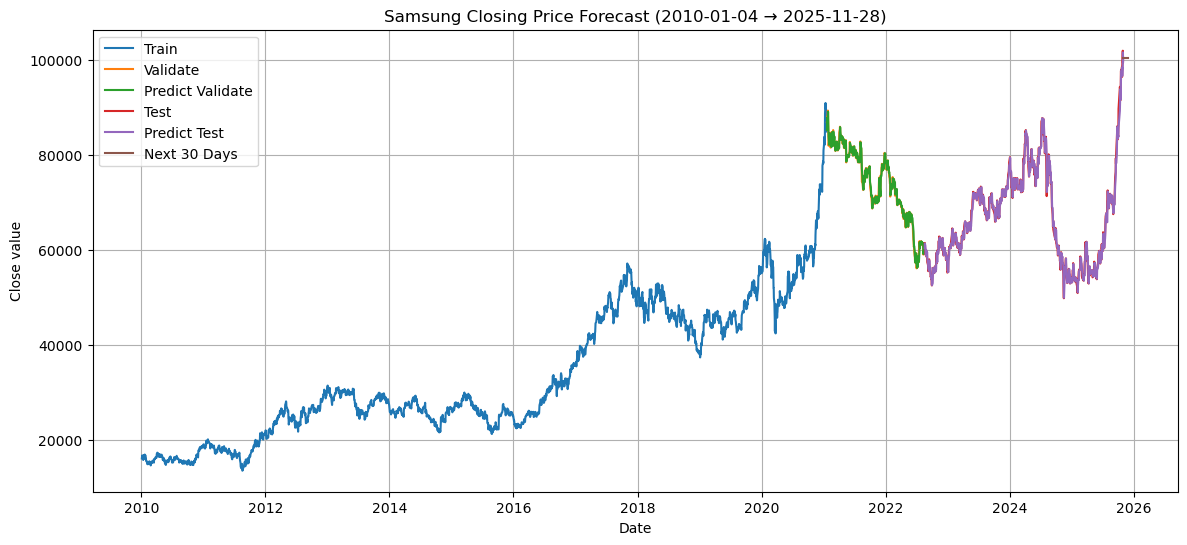

In [15]:
plt.figure(figsize=(14, 6))
plt.plot(df.index[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(df.index[train_size:train_size + val_size], scaler.inverse_transform(val_data), label='Validate')
plt.plot(df.index[train_size:train_size + val_size], best_y_pred_val, label='Predict Validate')
plt.plot(df.index[train_size + val_size:], scaler.inverse_transform(test_data), label='Test')
plt.plot(df.index[train_size + val_size:], y_pred_inv, label='Predict Test')
plt.plot(index_next_30_days, y_next_30_days_inv, label='Next 30 Days')

plt.grid()
plt.legend()
plt.title(f"Samsung Closing Price Forecast ({df.index[0].strftime('%Y-%m-%d')} → {index_next_30_days[-1].strftime('%Y-%m-%d')})")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig("EST_712_Samsung.png")
plt.show()
